In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import time

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Fungsi untuk membuat model LSTM atau BiLSTM
def create_model(input_shape, model_type='bilstm'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if model_type == 'bilstm':
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(64)))
    else:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Fungsi untuk membuat dataset dengan timestep
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Fungsi untuk evaluasi kromosom
def evaluate_chromosome(chromosome, X_train, y_train, X_test, y_test, timesteps, model_type='bilstm'):
    selected_features = [i for i in range(len(chromosome)) if chromosome[i] == 1]
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    X_train_t, y_train_t = create_dataset(X_train_selected, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test_selected, y_test, timesteps)

    model = create_model((X_train_t.shape[1], X_train_t.shape[2]), model_type)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

    model.fit(X_train_t, y_train_t, epochs=10, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    y_pred = model.predict(X_test_t)
    mse = mean_squared_error(y_test_t, y_pred)
    mae = mean_absolute_error(y_test_t, y_pred)
    r2 = r2_score(y_test_t, y_pred)
    mape = mean_absolute_percentage_error(y_test_t, y_pred)

    print(f"Evaluating chromosome {chromosome} -> MSE: {mse}, MAE: {mae}, R²: {r2}, MAPE: {mape}")
    return mse

# Fungsi untuk inisialisasi populasi
def initialize_population(pop_size, num_features):
    population = [np.random.randint(2, size=num_features) for _ in range(pop_size - 1)]
    # Tambahkan satu kromosom yang memiliki semua fitur diaktifkan
    population.append(np.ones(num_features, dtype=int))
    print(f"Initialized population: {population}")
    return population

# Fungsi untuk seleksi
def select(population, fitnesses, num_parents):
    indices = np.argsort(fitnesses)[:num_parents]
    parents = [population[i] for i in indices]
    print(f"Selected parents: {parents}")
    return parents

# Fungsi untuk crossover
def crossover(parents, offspring_size):
    offspring = []
    for _ in range(offspring_size):
        parent1, parent2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, len(parent1)-1)
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring.append(child)
        print(f"Crossover between {parent1} and {parent2} at {crossover_point} -> {child}")
    return offspring

# Fungsi untuk mutasi
def mutate(offspring, mutation_rate):
    for child in offspring:
        if random.random() < mutation_rate:
            mutation_point = random.randint(0, len(child)-1)
            child[mutation_point] = 1 - child[mutation_point]
            print(f"Mutated child {child} at {mutation_point}")
    return offspring

# Main GA function
def genetic_algorithm(X, y, timesteps_list, pop_size=5, num_generations=5, mutation_rate=0.1):
    num_features = X.shape[1]
    best_chromosomes = {}
    total_start_time = time.time()

    for timesteps in timesteps_list:
        print(f"\nRunning GA for feature selection with timesteps = {timesteps}")
        population = initialize_population(pop_size, num_features)
        start_time = time.time()

        for generation in range(num_generations):
            generation_start_time = time.time()
            fitnesses = np.array([evaluate_chromosome(chrom, X, y, X, y, timesteps) for chrom in population])
            best_fitness = np.min(fitnesses)
            best_chromosome = population[np.argmin(fitnesses)]

            parents = select(population, fitnesses, pop_size//2)
            offspring = crossover(parents, pop_size - len(parents))
            offspring = mutate(offspring, mutation_rate)
            population = np.concatenate((parents, offspring))

            generation_end_time = time.time()
            print(f"Generation {generation}: Best Fitness = {best_fitness}")
            print(f"Best Chromosome: {best_chromosome}")
            print(f"Population: {population}")
            print(f"Execution time for generation {generation}: {generation_end_time - generation_start_time:.2f} seconds")

        end_time = time.time()
        best_chromosomes[timesteps] = best_chromosome
        print(f"Best Features for timesteps = {timesteps}: {best_chromosome}")
        print(f"Execution time for timesteps {timesteps}: {end_time - start_time:.2f} seconds")

    total_end_time = time.time()
    print(f"Total execution time for GA: {total_end_time - total_start_time:.2f} seconds")

    return best_chromosomes

In [21]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_daily_meteostat.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
# df.drop('READ_DATE_day', axis=1, inplace=True)
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,tavg,tmin,tmax,wdir,wspd,pres
READ_DATE,,,,,,,
2019-01-01,1.704497,25.7,24.8,30.2,44.0,6.4,1008.9
2019-01-02,1.804380,26.0,24.1,29.2,21.0,5.4,1009.2
2019-01-03,1.606232,24.6,24.0,27.3,340.0,4.1,1010.3
2019-01-04,1.220510,26.2,23.0,29.8,340.0,6.9,1011.4
2019-01-05,0.980424,26.9,23.6,30.2,284.0,6.3,1011.7
...,...,...,...,...,...,...,...
2024-05-27,64.703542,28.3,24.4,34.0,126.0,9.9,1009.9
2024-05-28,63.751474,28.2,24.1,33.9,125.0,8.0,1009.4
2024-05-29,68.610622,29.0,24.2,33.0,130.0,7.7,1009.1


In [22]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
"""
READ_DATE
2019-01-01	11.001903	25.7	24.8	30.2	44.0	6.4	1008.9
2019-01-02	11.422662	26.0	24.1	29.2	21.0	5.4	1009.2
2019-01-03	2.341671	24.6	24.0	27.3	340.0	4.1	1010.3
2019-01-04	4.800008	26.2	23.0	29.8	340.0	6.9	1011.4
2019-01-05	5.752651	26.9	23.6	30.2	284.0	6.3	1011.7
...	...	...	...	...	...	...	...
2024-05-27	2.381903	28.3	24.4	34.0	126.0	9.9	1009.9
2024-05-28	2.412923	28.2	24.1	33.9	125.0	8.0	1009.4
2024-05-29	2.564494	29.0	24.2	33.0	130.0	7.7	1009.1
2024-05-30	2.558021	29.7	25.0	35.0	106.0	7.8	1009.7
2024-05-31	2.457463	29.8	25.5	35.2	121.0	9.6	1010.4
"""
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':'2024-05-24']
real_sim = df.loc['2024-05-25':'2024-05-31']

In [23]:
# # Create separate scalers for features and target
# feature_scaler = StandardScaler()
# target_scaler = StandardScaler()

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_features = pd.DataFrame(train_scaled_features, columns=train.columns, index=train.index)

# test_scaled_features = feature_scaler.transform(test)
# test_scaled_features = pd.DataFrame(test_scaled_features, columns=test.columns, index=test.index)

# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP']])
# test_scaled_target = target_scaler.transform(test[['KWH_EXP']])


In [24]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP']])
test_scaled_features = feature_scaler.transform(test)
test_scaled_target = target_scaler.transform(test[['KWH_EXP']])


In [25]:
train_scaled_features

array([[-1.08680743, -1.718197  ,  1.02028777, ..., -1.6810988 ,
        -1.08460424, -0.22940841],
       [-1.07385209, -1.43304526,  0.46910278, ..., -2.05933506,
        -1.53006888, -0.047088  ],
       [-1.09955293, -2.76375338,  0.39036207, ...,  3.18663736,
        -2.1091729 ,  0.62142017],
       ...,
       [-1.06980884, -1.52809584,  0.54784349, ...,  2.64395056,
        -0.41640729, -0.41172882],
       [-1.07348505, -1.52809584,  0.39036207, ...,  2.44660991,
         0.87544015, -0.22940841],
       [-1.0627245 , -0.19738772,  1.02028777, ...,  2.61106045,
         4.26097137, -0.59404923]])

In [26]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 3, 7]  # 1 hari, 3 hari, 1 minggu

# Run GA for feature selection for each timestep
best_chromosomes_bilstm = genetic_algorithm(train_scaled_features, train_scaled_target.ravel(), timesteps_list)


Running GA for feature selection with timesteps = 1
Initialized population: [array([0, 1, 1, 1, 1, 1, 1]), array([0, 1, 1, 1, 1, 1, 0]), array([1, 0, 1, 1, 0, 1, 0]), array([0, 0, 0, 0, 0, 1, 1]), array([1, 1, 1, 1, 1, 1, 1])]
Epoch 6: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Evaluating chromosome [0 1 1 1 1 1 1] -> MSE: 0.9261761061760135, MAE: 0.8233213411164096, R²: 0.07370845036825147, MAPE: 1.791584155960753
Epoch 8: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Evaluating chromosome [0 1 1 1 1 1 0] -> MSE: 0.9286516404489217, MAE: 0.8212626736256752, R²: 0.07123260753174576, MAPE: 1.9288669576551571
Epoch 8: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Evaluating chromosome [1 0 1 1 0 1 0] -> MSE: 0.05950243277966958, MAE: 0.14570468614650778, R²: 0.9404901505245002, MAPE: 1.1665302920116278
Epoch 6: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Evaluating chromosome [0 0 0 0 0 1 1] -> MSE: 0.9527221884158869, MAE: 0.8378870145729239, R²: 0

In [27]:
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=7):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Limit scope to the last part of the data
    scope_start = max(0, len(combined_actual) - (n_future + 28))
    scoped_actual = combined_actual[scope_start:]
    scoped_predicted = combined_predicted[scope_start:]

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(scoped_actual)), scoped_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(scoped_predicted)), scoped_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")



def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="bilstm", real_sim=real_sim, n_future=7)


In [28]:
print(best_chromosomes_bilstm.keys())

dict_keys([1, 3, 7])



Training model with selected features and timesteps = 1
Selected features: Index(['KWH_EXP', 'tavg', 'tmin', 'tmax', 'wspd'], dtype='object')
Epoch 32: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Results saved to bilstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


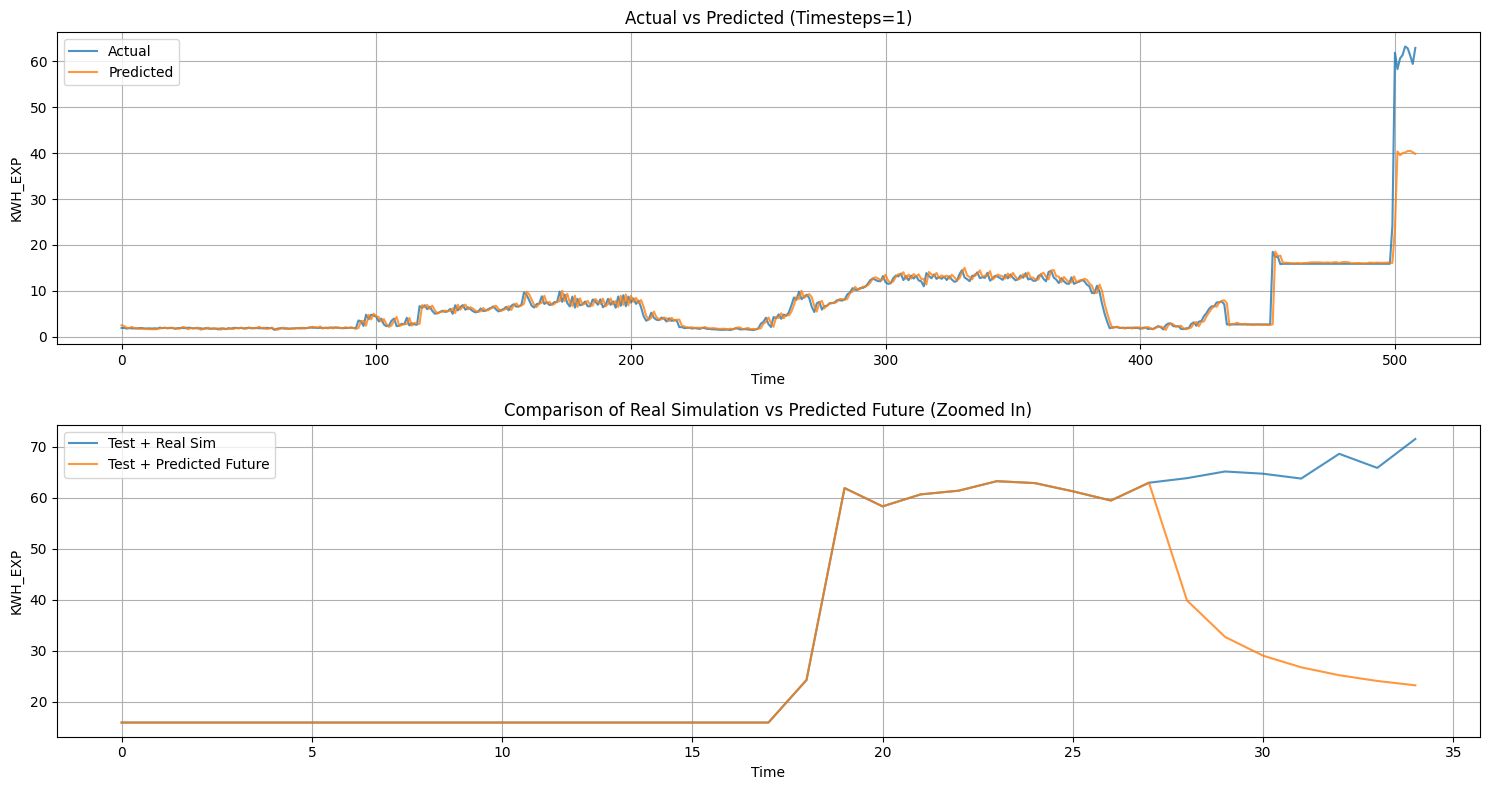


Metrics for timesteps=1:
MSE: 11.2610
R²: 0.8522
MAPE: 0.1117
MAE: 0.9946
Training time for timesteps = 1: 8.79 seconds

Training model with selected features and timesteps = 3
Selected features: Index(['KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres'], dtype='object')
Epoch 27: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


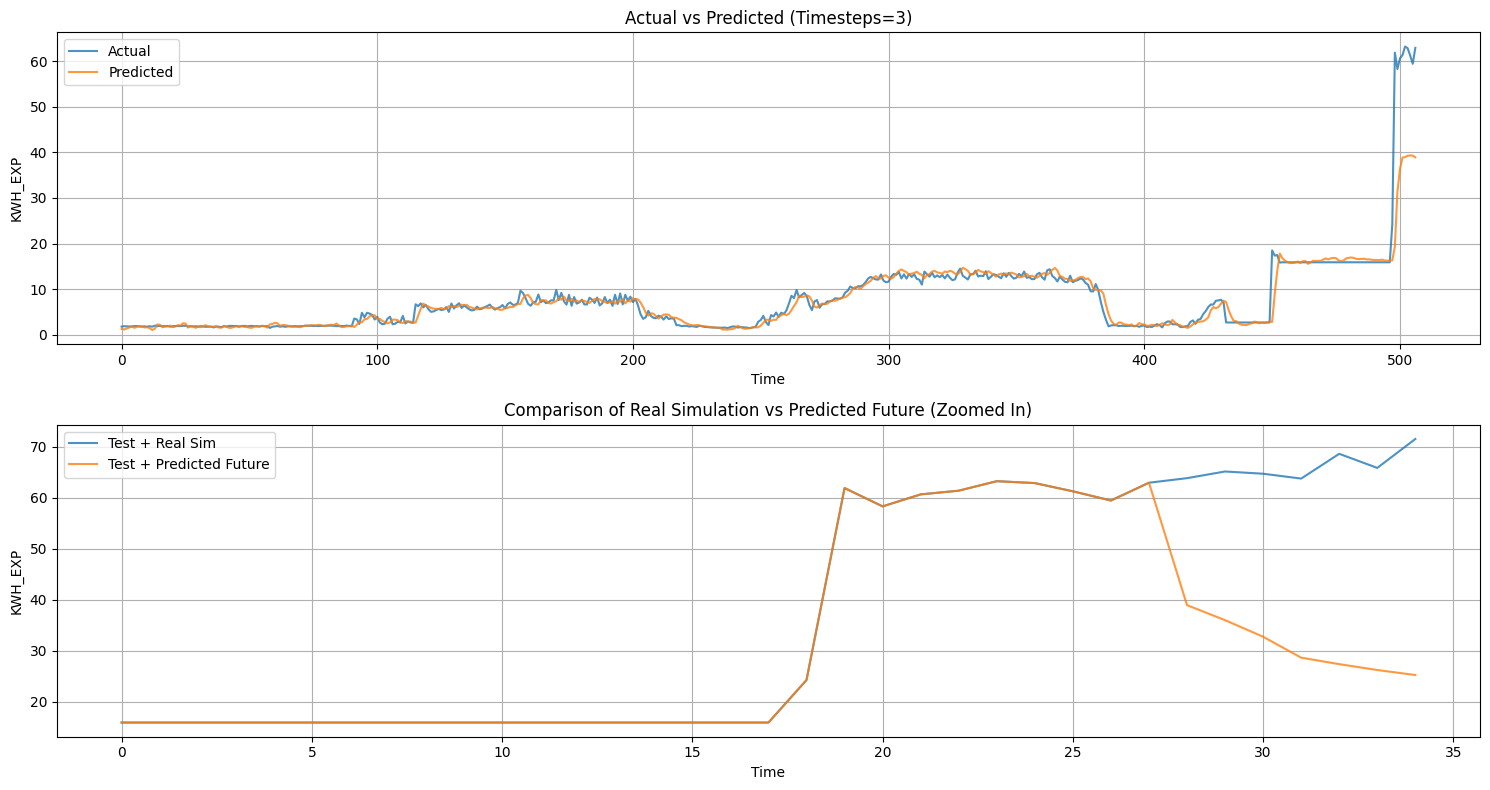


Metrics for timesteps=3:
MSE: 13.9268
R²: 0.8176
MAPE: 0.1444
MAE: 1.1644
Training time for timesteps = 3: 7.88 seconds

Training model with selected features and timesteps = 7
Selected features: Index(['KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres'], dtype='object')
Epoch 11: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Results saved to bilstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


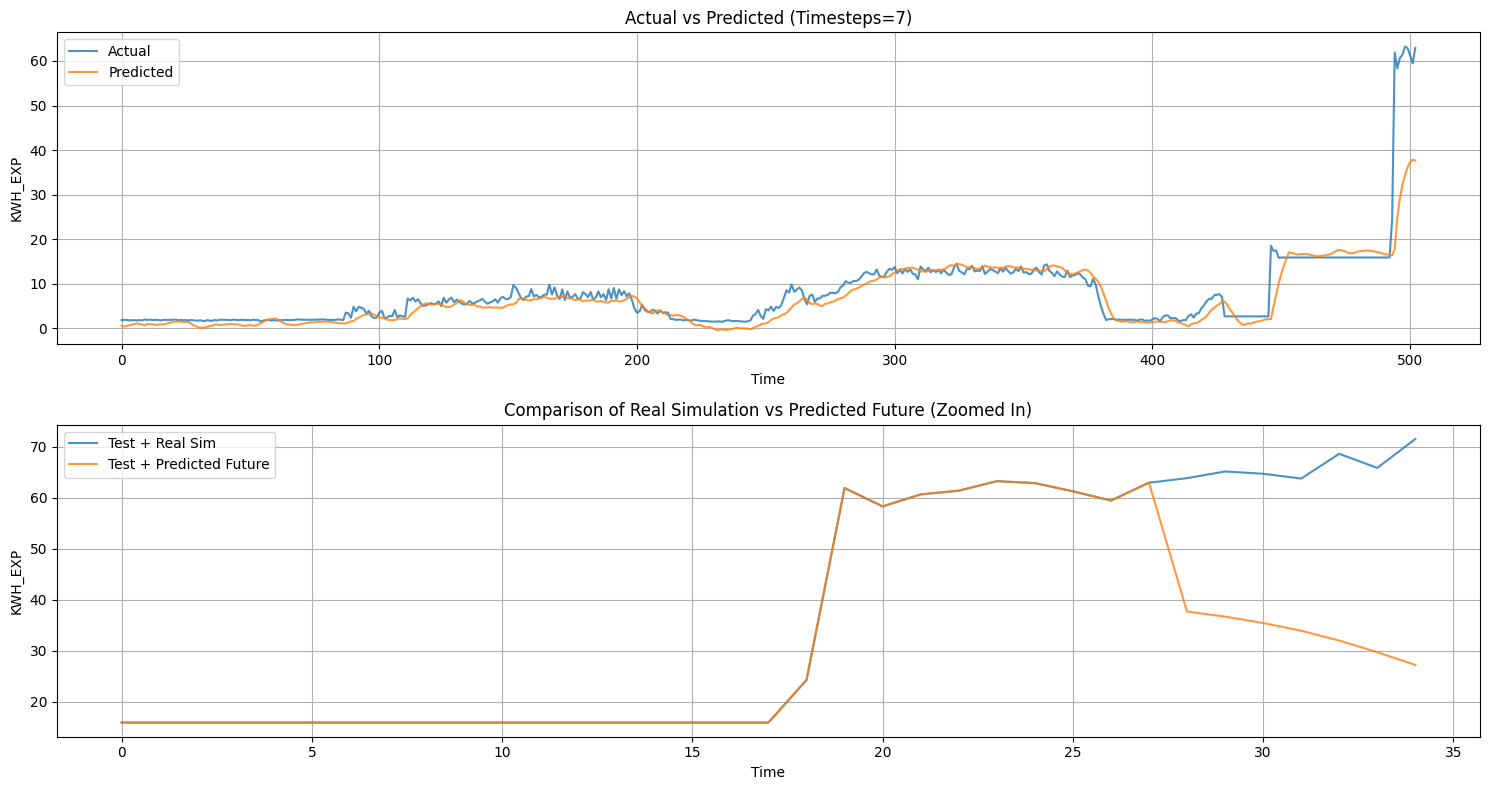


Metrics for timesteps=7:
MSE: 19.6614
R²: 0.7436
MAPE: 0.3097
MAE: 1.8147
Training time for timesteps = 7: 7.17 seconds
Total training execution time: 23.85 seconds


In [29]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    best_features = best_chromosomes_bilstm[ts]
    selected_features = [i for i in range(len(best_features)) if best_features[i] == 1]
    selected_feature_names = train.columns[selected_features]
    train_scaled_features_selected = train_scaled_features[:, selected_features]
    test_scaled_features_selected = test_scaled_features[:, selected_features]

    print(f"\nTraining model with selected features and timesteps = {ts}")
    print(f"Selected features: {selected_feature_names}")
    training_start_time = time.time()
    train_and_plot_bilstm(train_scaled_features_selected, train_scaled_target.ravel(), test_scaled_features_selected, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [30]:
# Fungsi untuk membuat model LSTM atau BiLSTM
def create_model(input_shape, model_type='lstm'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if model_type == 'bilstm':
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(64)))
    else:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Fungsi untuk membuat dataset dengan timestep
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Fungsi untuk evaluasi kromosom
def evaluate_chromosome(chromosome, X_train, y_train, X_test, y_test, timesteps, model_type='lstm'):
    selected_features = [i for i in range(len(chromosome)) if chromosome[i] == 1]
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    X_train_t, y_train_t = create_dataset(X_train_selected, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test_selected, y_test, timesteps)

    model = create_model((X_train_t.shape[1], X_train_t.shape[2]), model_type)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

    model.fit(X_train_t, y_train_t, epochs=10, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    y_pred = model.predict(X_test_t)
    mse = mean_squared_error(y_test_t, y_pred)
    mae = mean_absolute_error(y_test_t, y_pred)
    r2 = r2_score(y_test_t, y_pred)
    mape = mean_absolute_percentage_error(y_test_t, y_pred)

    print(f"Evaluating chromosome {chromosome} -> MSE: {mse}, MAE: {mae}, R²: {r2}, MAPE: {mape}")
    return mse

# Fungsi untuk inisialisasi populasi
def initialize_population(pop_size, num_features):
    population = [np.random.randint(2, size=num_features) for _ in range(pop_size - 1)]
    # Tambahkan satu kromosom yang memiliki semua fitur diaktifkan
    population.append(np.ones(num_features, dtype=int))
    print(f"Initialized population: {population}")
    return population

# Fungsi untuk seleksi
def select(population, fitnesses, num_parents):
    indices = np.argsort(fitnesses)[:num_parents]
    parents = [population[i] for i in indices]
    print(f"Selected parents: {parents}")
    return parents

# Fungsi untuk crossover
def crossover(parents, offspring_size):
    offspring = []
    for _ in range(offspring_size):
        parent1, parent2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, len(parent1)-1)
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring.append(child)
        print(f"Crossover between {parent1} and {parent2} at {crossover_point} -> {child}")
    return offspring

# Fungsi untuk mutasi
def mutate(offspring, mutation_rate):
    for child in offspring:
        if random.random() < mutation_rate:
            mutation_point = random.randint(0, len(child)-1)
            child[mutation_point] = 1 - child[mutation_point]
            print(f"Mutated child {child} at {mutation_point}")
    return offspring

# Main GA function
def genetic_algorithm(X, y, timesteps_list, pop_size=5, num_generations=5, mutation_rate=0.1):
    num_features = X.shape[1]
    best_chromosomes = {}
    total_start_time = time.time()

    for timesteps in timesteps_list:
        print(f"\nRunning GA for feature selection with timesteps = {timesteps}")
        population = initialize_population(pop_size, num_features)
        start_time = time.time()

        for generation in range(num_generations):
            generation_start_time = time.time()
            fitnesses = np.array([evaluate_chromosome(chrom, X, y, X, y, timesteps) for chrom in population])
            best_fitness = np.min(fitnesses)
            best_chromosome = population[np.argmin(fitnesses)]

            parents = select(population, fitnesses, pop_size//2)
            offspring = crossover(parents, pop_size - len(parents))
            offspring = mutate(offspring, mutation_rate)
            population = np.concatenate((parents, offspring))

            generation_end_time = time.time()
            print(f"Generation {generation}: Best Fitness = {best_fitness}")
            print(f"Best Chromosome: {best_chromosome}")
            print(f"Population: {population}")
            print(f"Execution time for generation {generation}: {generation_end_time - generation_start_time:.2f} seconds")

        end_time = time.time()
        best_chromosomes[timesteps] = best_chromosome
        print(f"Best Features for timesteps = {timesteps}: {best_chromosome}")
        print(f"Execution time for timesteps {timesteps}: {end_time - start_time:.2f} seconds")

    total_end_time = time.time()
    print(f"Total execution time for GA: {total_end_time - total_start_time:.2f} seconds")

    return best_chromosomes

In [31]:
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="lstm", real_sim=real_sim, n_future=7)


In [32]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 3, 7]  # 1 hari, 3 hari, 1 minggu

# Run GA for feature selection for each timestep
best_chromosomes_lstm = genetic_algorithm(train_scaled_features, train_scaled_target.ravel(), timesteps_list)


Running GA for feature selection with timesteps = 1
Initialized population: [array([1, 0, 0, 0, 1, 1, 0]), array([1, 1, 1, 0, 0, 0, 1]), array([1, 0, 0, 0, 0, 1, 0]), array([1, 0, 1, 0, 0, 0, 1]), array([1, 1, 1, 1, 1, 1, 1])]
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluating chromosome [1 0 0 0 1 1 0] -> MSE: 0.05862652173481684, MAE: 0.1411488936151662, R²: 0.9413661707475074, MAPE: 1.1953654887860914
Epoch 8: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Evaluating chromosome [1 1 1 0 0 0 1] -> MSE: 0.05818709701582908, MAE: 0.1399968690325263, R²: 0.9418056502387007, MAPE: 1.1642281231112293
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluating chromosome [1 0 0 0 0 1 0] -> MSE: 0.05755156522210949, MAE: 0.14078264734738763, R²: 0.942441261248442, MAPE: 1.1419504525125188
Epoch 9: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Evaluating chromosome [1 0 1 0 0 0 1] -> MSE: 0.06003344799785618, MAE: 0.14001145656699224, R²: 0.939959069117787, MAPE: 1.2074619594400589
46/4


Training model with selected features and timesteps = 1
Selected features: Index(['KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres'], dtype='object')
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Results saved to lstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


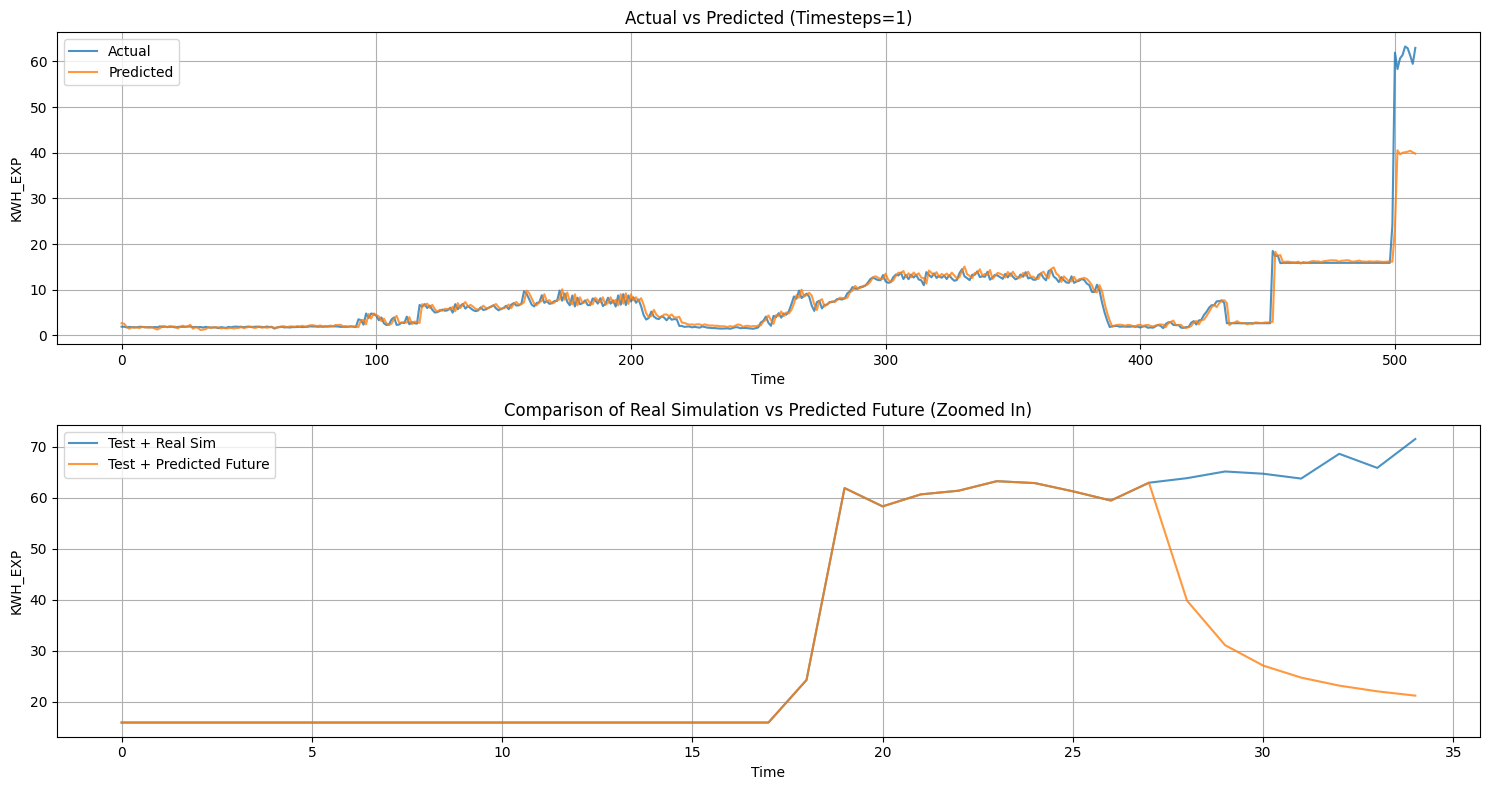


Metrics for timesteps=1:
MSE: 11.3002
R²: 0.8517
MAPE: 0.1347
MAE: 1.0438
Training time for timesteps = 1: 7.35 seconds

Training model with selected features and timesteps = 3
Selected features: Index(['KWH_EXP'], dtype='object')
Epoch 13: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


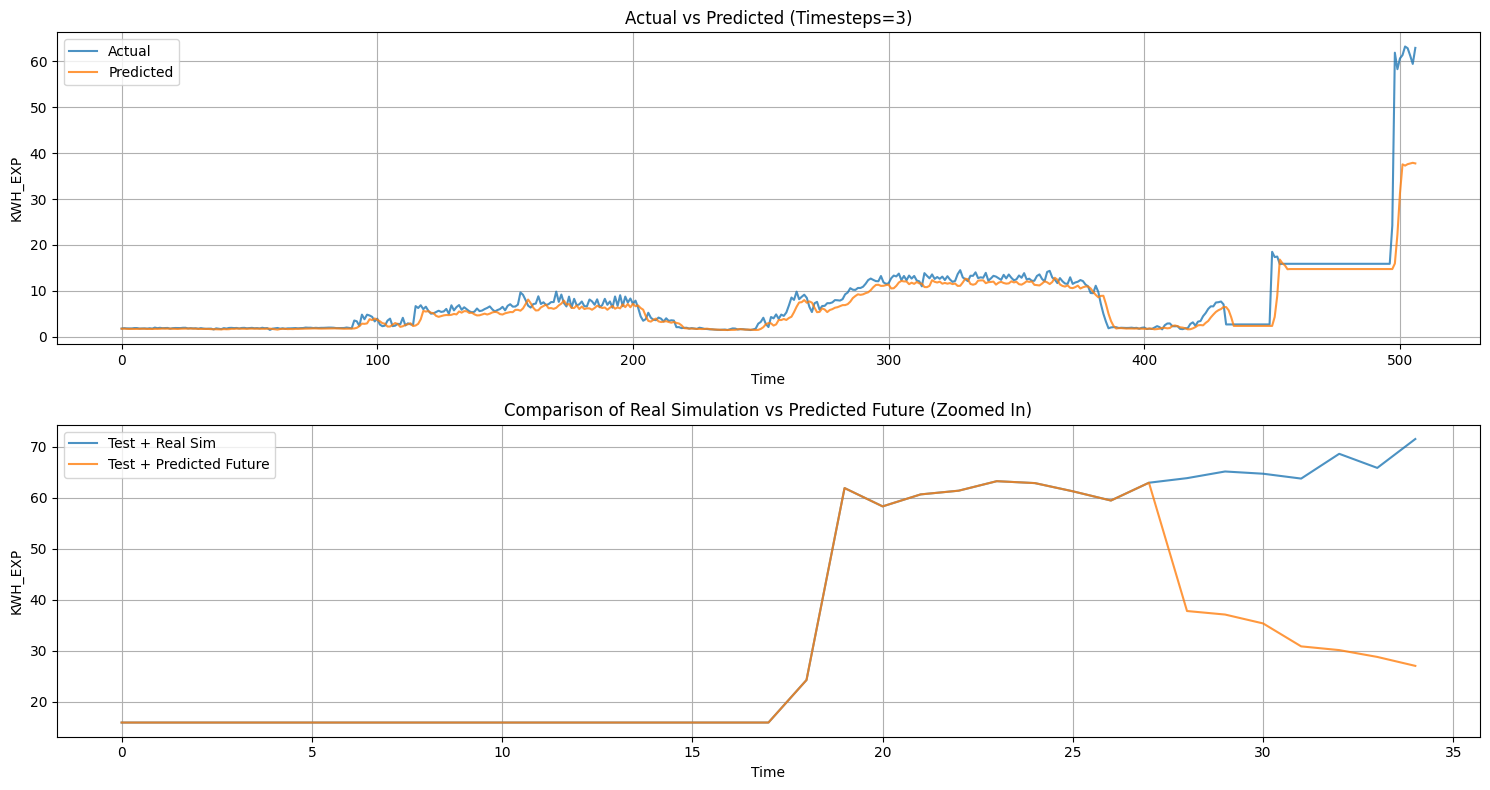


Metrics for timesteps=3:
MSE: 18.0296
R²: 0.7639
MAPE: 0.1532
MAE: 1.4598
Training time for timesteps = 3: 3.73 seconds

Training model with selected features and timesteps = 7
Selected features: Index(['KWH_EXP', 'tavg', 'tmin', 'tmax', 'wspd', 'pres'], dtype='object')
Epoch 16: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Results saved to lstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


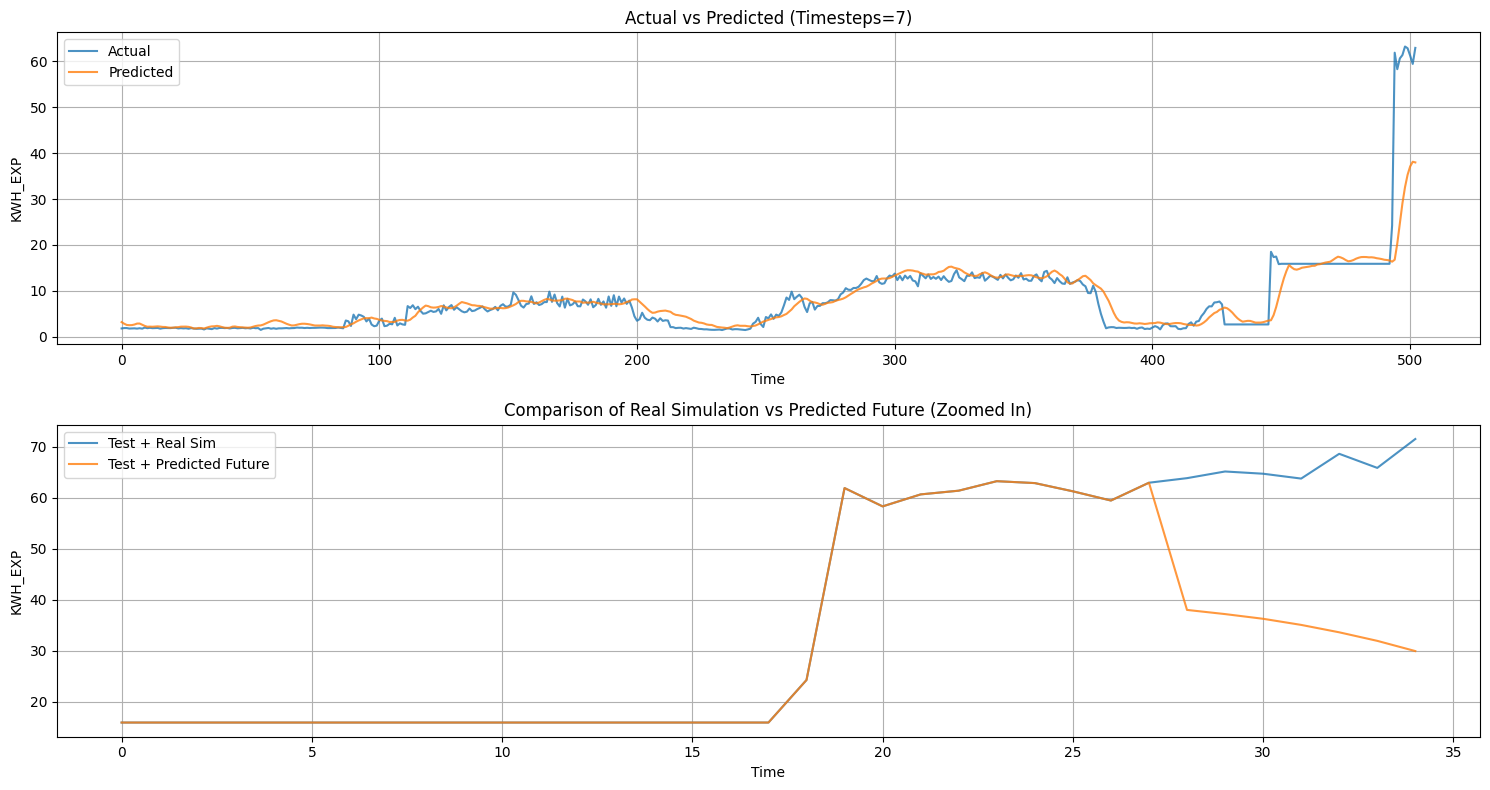


Metrics for timesteps=7:
MSE: 21.4440
R²: 0.7203
MAPE: 0.2853
MAE: 1.6932
Training time for timesteps = 7: 5.88 seconds
Total training execution time: 16.97 seconds


In [33]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    best_features = best_chromosomes_lstm[ts]
    selected_features = [i for i in range(len(best_features)) if best_features[i] == 1]
    selected_feature_names = train.columns[selected_features]
    train_scaled_features_selected = train_scaled_features[:, selected_features]
    test_scaled_features_selected = test_scaled_features[:, selected_features]

    print(f"\nTraining model with selected features and timesteps = {ts}")
    print(f"Selected features: {selected_feature_names}")
    training_start_time = time.time()
    train_and_plot_lstm(train_scaled_features_selected, train_scaled_target.ravel(), test_scaled_features_selected, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [34]:
# not zoom in
"""
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=48):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

        # Print metrics
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(combined_actual)), combined_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(combined_predicted)), combined_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
  """

'\ndef plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=48):\n    # Make predictions\n    y_pred = model.predict(X_test_t)\n    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))\n    y_pred_orig = target_scaler.inverse_transform(y_pred)\n\n    # Create DataFrame for Actual vs Predicted\n    results_df = pd.DataFrame({\n        \'Actual\': y_test_orig.flatten(),\n        \'Predicted\': y_pred_orig.flatten()\n    })\n\n    # Save DataFrame to CSV with model name and timesteps\n    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"\n    results_df.to_csv(file_name, index=False)\n    print(f"Results saved to {file_name}")\n\n    # Plot Actual vs Predicted\n    plt.figure(figsize=(15, 8))\n    plt.subplot(2, 1, 1)\n    plt.plot(results_df[\'Actual\'], label=\'Actual\', alpha=0.8)\n    plt.plot(results_df[\'Predicted\'], label=\'Predicted\', alpha=0.8)\n    plt.title(f\'Actual vs Predicted (Timesteps={timestep